In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

C:\Users\ErandaniD\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('creditcard.csv')
pd.set_option('display.max_columns',None)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#Features V1, V2, … V28 are the principal components obtained with PCA, 
#the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
#The Time feature shows the absolute time of the transaction, which makes the data a bit hard to deal with here. 
#The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. 
#Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Dataset is highly imblanced as frauds are rare cases

##### Lets vishualize high-dimensional data, in 2-dimensional space using PCA

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [6]:
df1 = df.drop('Time', axis=1)
X1 = df1.drop('Class', axis=1)
y1 = df1['Class']

In [7]:
scaler = StandardScaler()
X1 = pd.DataFrame(scaler.fit_transform(X1), columns=X1.columns)

In [9]:
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(X1), columns=['pca1','pca2'])
df_pca['Class'] = df['Class']

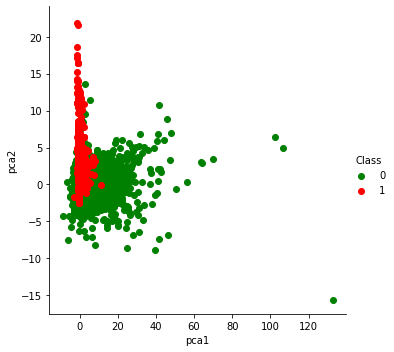

In [10]:
col = {0:'g', 1:'r'}
sb.FacetGrid(data=df_pca, hue='Class', palette=col, height=5).map(plt.scatter,'pca1','pca2').add_legend()
plt.show()

Initially data cannot be observed as 2 seperate cluaters

#### Preparing Dataset

We are going to train our Autoencoder model, only using non-fraudulent cases. So when we deploy trained model, as the model has only seen non-fraudulent cases, it generates higher error-score when fraudulent case occurs. 

In [11]:
df2 = df1[df1['Class']==0]
X = df2.drop('Class', axis=1)
y = df2['Class']

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [15]:
df3= df1[df1['Class']==1]
X_test_new = df3.drop('Class', axis=1)
y_test_new = df3['Class']

X_test_final = pd.concat([X_test,X_test_new], axis=0)
y_test_final = pd.concat([y_test,y_test_new], axis=0)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_final = pd.DataFrame(scaler.fit_transform(X_test_final), columns=X_test_final.columns)

#### Fitting Auto Encoder Model

In [17]:
from pyod.models.auto_encoder import AutoEncoder

Using TensorFlow backend.


##### (1) Building the model

In [18]:
#define layers symetrically
clf1 = AutoEncoder(hidden_neurons =[20, 8, 20])
clf1.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 29)                870       
_________________________________________________________________
dropout_1 (Dropout)          (None, 29)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 29)                870       
_________________________________________________________________
dropout_2 (Dropout)          (None, 29)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                600       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                

204706/204706 [==============================] - 11s 51us/step - loss: 0.9992 - val_loss: 1.0071
Epoch 59/100
204706/204706 [==============================] - 10s 51us/step - loss: 0.9992 - val_loss: 1.0071
Epoch 60/100
204706/204706 [==============================] - 10s 51us/step - loss: 0.9992 - val_loss: 1.0071
Epoch 61/100
204706/204706 [==============================] - 10s 50us/step - loss: 0.9992 - val_loss: 1.0071
Epoch 62/100
204706/204706 [==============================] - 12s 59us/step - loss: 0.9992 - val_loss: 1.0071
Epoch 63/100
204706/204706 [==============================] - 11s 52us/step - loss: 0.9992 - val_loss: 1.0071
Epoch 64/100
204706/204706 [==============================] - 10s 49us/step - loss: 0.9992 - val_loss: 1.0071
Epoch 65/100
204706/204706 [==============================] - 10s 50us/step - loss: 0.9992 - val_loss: 1.0071
Epoch 66/100
204706/204706 [==============================] - 10s 48us/step - loss: 0.9992 - val_loss: 1.0071
Epoch 67/100
204706/204

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[20, 8, 20],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x000001A274540D38>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

##### (2) Determine the Cut Point

> Now we apply the trained model Clf1 to predict the anomaly score for each observation in the test data

> An outlier is a point that is distant from other points, so the outlier score is defined by distance

> The PyOD function ".decision_function() calculates the distance or the anomaly score for each data point

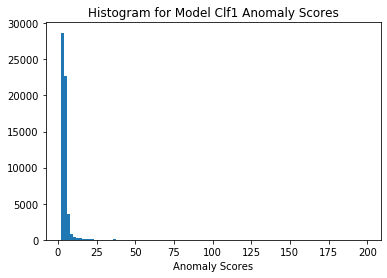

In [23]:
# Get the outlier scores for the train data
y_train_scores = clf1.decision_scores_  

# Predict the anomaly scores test data
y_test_scores = clf1.decision_function(X_test_final)  # outlier scores
y_test_scores = pd.Series(y_test_scores)


plt.hist(y_test_scores, bins=100)  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.xlabel("Anomaly Scores")
plt.show()

Zooming y_test_scores>25 distribution, to have a clear view :

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
y_test_scores1 = y_test_scores[y_test_scores>25]

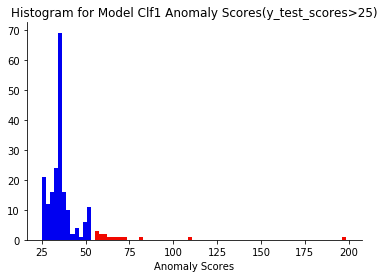

In [48]:
N, bins, patches= plt.hist(y_test_scores1, bins=75)

cmap = plt.get_cmap('jet')
low = cmap(0.1)
medium =cmap(0.9)

for i in range(0,12):
    patches[i].set_facecolor(low)
for i in range(13,75):
    patches[i].set_facecolor(medium)



plt.xlabel("Anomaly Scores")
plt.title("Histogram for Model Clf1 Anomaly Scores(y_test_scores>25)")
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plt.show()

we can see the high scores corresponds to low frequency are outliers.

We can choose 50 to be the cut point and those >=50 to be outliers.

##### (3) Get the Summary Statistics by Cluster

In [50]:
#assign less than 50 anomaly scores to Cluster 0, and to Cluster 1 for those above 50

df_test = X_test_final.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = df_test['score'].apply(lambda x: 1 if x > 50 else 0 )
print(df_test['cluster'].value_counts())

df_test.groupby('cluster').mean()

0    57329
1       26
Name: cluster, dtype: int64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,score
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.004717,0.002162,0.003550,-0.002172,0.003454,-0.002652,0.000483,0.007415,0.000408,0.001704,-0.000973,0.001017,0.000016,0.001051,-0.000462,0.000197,0.001722,0.000876,-0.000008,0.000613,0.000216,0.000456,-0.000377,-0.000192,0.000275,0.000179,0.001470,-0.002883,-0.005106,4.439544
1,-10.401116,-4.766502,-7.827575,4.788321,-7.614875,5.848243,-1.064380,-16.349694,-0.899466,-3.757952,2.144405,-2.242284,-0.034873,-2.316920,1.019134,-0.433677,-3.796129,-1.930961,0.018224,-1.352439,-0.476840,-1.006023,0.831783,0.422286,-0.605836,-0.394749,-3.241688,6.356315,11.258829,65.740143


the results show the summary statistics of Cluster ‘1’ (the abnormal cluster) is highly deviated from those of Cluster ‘0’ (the normal cluster).

The observations in Cluster 1 are outliers.